In [25]:
import mne
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


In [2]:
raw = mne.io.read_raw_edf('/Users/rotemfalach/Documents/University/lab/Lilach_new/416_for_tag.edf')
spikes = raw.annotations

Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/Lilach_new/416_for_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
spikes

<Annotations | 72 segments: END (1), Lt spike (29), Rt spike (42)>

In [4]:
spikes_df = pd.DataFrame(spikes)
end_onset = list(spikes_df[spikes_df['description'].str.contains('END')]['onset'])[0]
spikes_df = spikes_df[spikes_df['onset'] < end_onset]
spikes_df = spikes_df[spikes_df['description'].str.contains('Rt')]
# spikes_df.onset = spikes_df.onset.astype(int)
spikes_df = spikes_df.drop_duplicates(subset=['onset'])

In [5]:
len(spikes_df)

37

In [6]:
spikes_df

,onset,duration,description,orig_time
5,7.8684,0.0,Rt spike,2009-07-22 23:38:30+00:00
6,9.4970,0.0,Rt spike,2009-07-22 23:38:30+00:00
8,10.1648,0.0,Rt spike,2009-07-22 23:38:30+00:00
9,11.5555,0.0,Rt spike,2009-07-22 23:38:30+00:00
11,12.4522,0.0,Rt spike,2009-07-22 23:38:30+00:00
16,19.1292,0.0,Rt spike,2009-07-22 23:38:30+00:00
17,20.1896,0.0,Rt spike,2009-07-22 23:38:30+00:00
19,22.1932,0.0,Rt spike,2009-07-22 23:38:30+00:00
23,25.4420,0.0,Rt spike,2009-07-22 23:38:30+00:00
24,25.4613,0.0,Rt spike,2009-07-22 23:38:30+00:00


In [7]:
raw_data = raw.crop(tmax=end_onset).pick_channels(['RAH1']).resample(500).get_data()[0]

In [8]:
series_windows = []
for i in range(0, len(raw_data), 2000):
    if i + 2000 < len(raw_data):
        series_windows.append(raw_data[i: i+2000])
#     print(i)
# raw_data[0]

In [9]:
features_df = pd.concat([pd.DataFrame(np.arange(2000), columns=['id']), 
           pd.DataFrame(np.arange(2000), columns=['time']), 
           pd.DataFrame(series_windows[0], columns=['amp'])], axis=1)

In [10]:
y_windows = np.zeros(len(series_windows))
for onset in spikes_df['onset']:
    y_windows[int(onset)] = 1

IndexError: index 62 is out of bounds for axis 0 with size 50

In [11]:
y = np.zeros(len(raw_data))
for x in spikes_df['onset']:
    if x * 1000 + 101 < len(y):
        y[int(x * 1000) - 100: int(x * 1000) + 100] = 1
y = pd.DataFrame(y)
y[0]

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
100772    0.0
100773    0.0
100774    0.0
100775    0.0
100776    0.0
Name: 0, Length: 100777, dtype: float64

In [34]:
pd.options.display.precision = 10

In [27]:
raw_data

array([-2.77976772e-04, -2.93842001e-04, -3.04980805e-04, ...,
       -4.33986495e-05, -4.99337493e-05, -6.17171388e-05])

In [35]:
# from sktime.transformers.series_as_features.summarize import TSFreshFeatureExtractor

# transformer = TSFreshFeatureExtractor(default_fc_parameters="minimal")
# extracted_features = transformer.fit_transform(X_train)
# extracted_features.head()
X = pd.concat([pd.DataFrame(np.arange(len(raw_data)), columns=['id']),
               pd.DataFrame(np.arange(len(raw_data)), columns=['time']),
               pd.DataFrame(raw_data, columns=['amp'])], axis=1)
X

,id,time,amp
0,0,0,-0.0002779768
1,1,1,-0.0002938420
2,2,2,-0.0003049808
3,3,3,-0.0003128303
4,4,4,-0.0003199486
...,...,...,...
100772,100772,100772,-0.0000397937
100773,100773,100773,-0.0000357934
100774,100774,100774,-0.0000433986
100775,100775,100775,-0.0000499337


In [36]:
from tsfresh import extract_relevant_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

extracted_features = extract_relevant_features(X, y[0], column_id="id", column_sort="time")
extracted_features

Feature Extraction: 100%|██████████| 20/20 [14:13<00:00, 42.70s/it]


,amp__sum_values,"amp__fft_coefficient__attr_""real""__coeff_0","amp__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","amp__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","amp__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","amp__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",amp__quantile__q_0.9,amp__quantile__q_0.8,amp__quantile__q_0.7,amp__quantile__q_0.4,...,amp__quantile__q_0.2,amp__quantile__q_0.1,amp__minimum,amp__maximum,amp__mean,amp__median,amp__quantile__q_0.3,amp__root_mean_square,amp__abs_energy,"amp__fft_coefficient__attr_""abs""__coeff_0"
0,-0.0002779768,-0.0002779768,-0.0000539108,-0.0000762413,-0.0001078215,-0.0001704808,-0.0002779768,-0.0002779768,-0.0002779768,-0.0002779768,...,-0.0002779768,-0.0002779768,-0.0002779768,-0.0002779768,-0.0002779768,-0.0002779768,-0.0002779768,0.0002779768,0.0000000773,0.0002779768
1,-0.0002938420,-0.0002938420,-0.0000569877,-0.0000805927,-0.0001139753,-0.0001802108,-0.0002938420,-0.0002938420,-0.0002938420,-0.0002938420,...,-0.0002938420,-0.0002938420,-0.0002938420,-0.0002938420,-0.0002938420,-0.0002938420,-0.0002938420,0.0002938420,0.0000000863,0.0002938420
2,-0.0003049808,-0.0003049808,-0.0000591479,-0.0000836478,-0.0001182958,-0.0001870421,-0.0003049808,-0.0003049808,-0.0003049808,-0.0003049808,...,-0.0003049808,-0.0003049808,-0.0003049808,-0.0003049808,-0.0003049808,-0.0003049808,-0.0003049808,0.0003049808,0.0000000930,0.0003049808
3,-0.0003128303,-0.0003128303,-0.0000606702,-0.0000858007,-0.0001213405,-0.0001918561,-0.0003128303,-0.0003128303,-0.0003128303,-0.0003128303,...,-0.0003128303,-0.0003128303,-0.0003128303,-0.0003128303,-0.0003128303,-0.0003128303,-0.0003128303,0.0003128303,0.0000000979,0.0003128303
4,-0.0003199486,-0.0003199486,-0.0000620508,-0.0000877530,-0.0001241015,-0.0001962217,-0.0003199486,-0.0003199486,-0.0003199486,-0.0003199486,...,-0.0003199486,-0.0003199486,-0.0003199486,-0.0003199486,-0.0003199486,-0.0003199486,-0.0003199486,0.0003199486,0.0000001024,0.0003199486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100772,-0.0000397937,-0.0000397937,-0.0000077176,-0.0000109143,-0.0000154352,-0.0000244051,-0.0000397937,-0.0000397937,-0.0000397937,-0.0000397937,...,-0.0000397937,-0.0000397937,-0.0000397937,-0.0000397937,-0.0000397937,-0.0000397937,-0.0000397937,0.0000397937,0.0000000016,0.0000397937
100773,-0.0000357934,-0.0000357934,-0.0000069418,-0.0000098171,-0.0000138835,-0.0000219518,-0.0000357934,-0.0000357934,-0.0000357934,-0.0000357934,...,-0.0000357934,-0.0000357934,-0.0000357934,-0.0000357934,-0.0000357934,-0.0000357934,-0.0000357934,0.0000357934,0.0000000013,0.0000357934
100774,-0.0000433986,-0.0000433986,-0.0000084167,-0.0000119030,-0.0000168334,-0.0000266160,-0.0000433986,-0.0000433986,-0.0000433986,-0.0000433986,...,-0.0000433986,-0.0000433986,-0.0000433986,-0.0000433986,-0.0000433986,-0.0000433986,-0.0000433986,0.0000433986,0.0000000019,0.0000433986
100775,-0.0000499337,-0.0000499337,-0.0000096841,-0.0000136954,-0.0000193683,-0.0000306239,-0.0000499337,-0.0000499337,-0.0000499337,-0.0000499337,...,-0.0000499337,-0.0000499337,-0.0000499337,-0.0000499337,-0.0000499337,-0.0000499337,-0.0000499337,0.0000499337,0.0000000025,0.0000499337


In [37]:
X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, stratify=y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

(75582, 21) (75582, 1) (25195, 21) (25195, 1)
[0. 1.] [72695  2887]


In [38]:
# now we can apply any scikit-learn classifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


/Users/rotemfalach/projects/mne-python/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[24201,    32],
       [  958,     4]])

In [40]:
def get_metrics(cm):
    if len(cm) == 0:
        cm = np.zeros((2,2), dtype=int)
    if np.squeeze(cm).ndim < 2:
        new_cm = np.zeros((2,2), dtype=int)
        new_cm[1, 1] = int(cm[0][0])
        cm = new_cm
    numerator = cm[0, 0] + cm[1, 1]
    denominator = cm[0, 0] + cm[1, 1] + cm[0, 1] + cm[1, 0]
    accuracy = numerator / denominator
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    numerator = precision * recall
    denominator = (0.25 * precision) + recall
    f_score = 1.25 * numerator / denominator
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f_score': f_score}

In [41]:
get_metrics(cm)

{'accuracy': 0.960706489382814,
 'precision': 0.1111111111111111,
 'recall': 0.004158004158004158,
 'f_score': 0.018083182640144666}

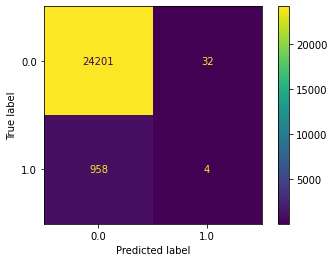

In [42]:
plot_confusion_matrix(classifier, X_test, y_test)  